In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.decomposition import PCA
import umap.umap_ as umap
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import optuna
from optuna.exceptions import TrialPruned
from pathlib import Path
file_path = Path('Data/Dataset4_EWS.xlsx')


In [28]:
# Load data
data_df = pd.read_excel(file_path, sheet_name='Markets')
# Convert date and set index
date_col = 'Date' if 'Date' in data_df.columns else data_df.columns[0]
data_df[date_col] = pd.to_datetime(data_df[date_col], dayfirst=True)
data_df = data_df.set_index(date_col)
# Separate features and label
y_col = 'Y' if 'Y' in data_df.columns else None
if y_col:
    X_df = data_df.drop(y_col, axis=1)
    y = data_df[y_col].values
else:
    X_df = data_df
    y = None

# Stationarize as before
indices_currencies = [col for col in X_df.columns if col in [
    'XAUBGNL','BDIY','CRY','Cl1','DXY','EMUSTRUU','GBP','JPY','LF94TRUU',
    'LF98TRUU','LG30TRUU','LMBITR','LP01TREU','LUACTRUU','LUMSTRUU',
    'MXBR','MXCN','MXEU','MXIN','MXJP','MXRU','MXUS','VIX'
]]
interest_rates = [col for col in X_df.columns if col in [
    'EONIA','GTDEM10Y','GTDEM2Y','GTDEM30Y','GTGBP20Y','GTGBP2Y','GTGBP30Y',
    'GTITL10YR','GTITL2YR','GTITL30YR','GTJPY10YR','GTJPY2YR','GTJPY30YR',
    'US0001M','USGG3M','USGG2YR','GT10','USGG30YR'
]]

stationary_df = pd.DataFrame(index=X_df.index[1:])
for col in indices_currencies:
    if col in X_df.columns:
        stationary_df[col] = np.diff(np.log(X_df[col]))
for col in interest_rates:
    if col in X_df.columns:
        stationary_df[col] = np.diff(X_df[col])
if 'ECSURPUS' in X_df.columns:
    stationary_df['ECSURPUS'] = X_df['ECSURPUS'].values[1:]

# Align label
y_stationary = y[1:] if y is not None else None

In [29]:
# 2. Create sequences for LSTM
def create_sequences(X, y, seq_length=30):
    """
    Build sliding-window sequences of length `seq_length`.
    Labels are assigned to the last timestep in each sequence.
    """
    sequences = []
    seq_labels = []
    for i in range(len(X) - seq_length + 1):
        seq = X[i : i + seq_length]
        label = y[i + seq_length - 1] if y is not None else 0
        sequences.append(seq)
        seq_labels.append(label)
    return np.stack(sequences), np.array(seq_labels)

# Convert to numpy and scale
X = stationary_df.values
y = y_stationary
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## **LSTM**
> Ordinary RNNs try to “remember” the past by feeding the hidden state forward one step at a time, but their gradients either explode or vanish when sequences are long. LSTM introduces an explicit memory cell and gating mechanisms so information can flow unchanged when necessary, letting the network model dependencies dozens or hundreds of steps back.

At timestep t, the cell receives:

> **current input**

>**previous hidden state**

>**previous cell state – the long-term memory**

Because $c_t$ is modified by element-wise products instead of full matrix multiplications, gradients can flow through many steps with little attenuation.

## **In an autoencoder setup, an LSTM encoder compresses a sequence into a latent vector; a decoder tries to reconstruct the original. Large reconstruction error ⇒ unusual sequence ⇒ anomaly.**

In [30]:
class LSTMAutoencoder(nn.Module):
    def __init__(self, n_features, hidden_dim, num_layers):
        super().__init__()
        self.encoder = nn.LSTM(n_features, hidden_dim, num_layers, batch_first=True)
        self.decoder = nn.LSTM(hidden_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, n_features)

    def forward(self, x):
        _, (h_n, _) = self.encoder(x)
        h = h_n[-1]
        dec_input = h.unsqueeze(1).repeat(1, x.size(1), 1)
        dec_out, _ = self.decoder(dec_input)
        return self.fc(dec_out)

    # --- Visualization Utilities ---
    def plot_roc(self, y_true, y_score, model_name):
        fpr, tpr, _ = roc_curve(y_true, y_score)
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(8,6))
        plt.plot(fpr, tpr, lw=2, label=f'AUC = {roc_auc:.2f}')
        plt.plot([0,1], [0,1], linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve — {model_name}')
        plt.legend(loc='lower right')
        plt.tight_layout()
        plt.show()

    def plot_precision_recall(self, y_true, y_score, model_name):
        precision, recall, _ = precision_recall_curve(y_true, y_score)
        ap = average_precision_score(y_true, y_score)
        plt.figure(figsize=(8,6))
        plt.plot(recall, precision, lw=2, label=f'AP = {ap:.2f}')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'Precision–Recall Curve — {model_name}')
        plt.legend(loc='upper right')
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

    def plot_score_histogram(self, y_true, y_score, model_name):
        plt.figure(figsize=(8,6))
        sns.histplot(y_score[y_true==0], label='Normal', stat='density', kde=True)
        sns.histplot(y_score[y_true==1], label='Anomaly', stat='density', kde=True)
        plt.xlabel('Anomaly Score')
        plt.title(f'Score Distribution — {model_name}')
        plt.legend()
        plt.tight_layout()
        plt.show()

    def plot_confusion_matrix(self, y_true, y_pred, model_name):
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(6,5))
        sns.heatmap(cm, annot=True, fmt='d', cbar=False)
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title(f'Confusion Matrix — {model_name}')
        plt.tight_layout()
        plt.show()
    def plot_pca(self, X, y_true, y_pred, model_name):
        """
        PCA scatter with custom legend categories and counts.
        """
        # 1) project to 2D
        proj = PCA(n_components=2).fit_transform(X)

        # 2) build a DataFrame with category labels
        df = pd.DataFrame(proj, columns=['PC1','PC2'])
        df['Actual']    = y_true
        df['Predicted'] = y_pred
        df['Category']  = 'Unknown'
        df.loc[(df.Actual == 1)&(df.Predicted == 1), 'Category'] = 'True Positive'
        df.loc[(df.Actual == 0)&(df.Predicted == 0), 'Category'] = 'True Negative'
        df.loc[(df.Actual == 0)&(df.Predicted == 1), 'Category'] = 'False Positive'
        df.loc[(df.Actual == 1)&(df.Predicted == 0), 'Category'] = 'False Negative'

        # 3) define color+marker mapping (all circles)
        mapping = {
            'False Negative': {'color':'blue',   'marker':'o'},
            'False Positive': {'color':'red',    'marker':'o'},
            'True Negative':  {'color':'grey',   'marker':'o'},
            'True Positive':  {'color':'black',  'marker':'o'}
        }

        # 4) plot
        plt.figure(figsize=(8,6))
        for cat, grp in df.groupby('Category'):
            count = len(grp)
            plt.scatter(
                grp['PC1'], grp['PC2'],
                c=mapping[cat]['color'],
                marker=mapping[cat]['marker'],
                alpha=0.7,
                label=f"{cat} ({count})"
            )
        plt.title(f'PCA Projection — {model_name}')
        plt.xlabel('PC1'); plt.ylabel('PC2')
        plt.legend(loc='best')
        plt.tight_layout()
        plt.show()


    def plot_umap(self, X, y_true, y_pred, model_name):
        """
        UMAP scatter with custom legend categories and counts.
        """
        # 1) project via UMAP
        proj = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42).fit_transform(X)

        # 2) build DataFrame with labels
        df = pd.DataFrame(proj, columns=['UMAP1','UMAP2'])
        df['Actual']    = y_true
        df['Predicted'] = y_pred
        df['Category']  = 'Unknown'
        df.loc[(df.Actual == 1)&(df.Predicted == 1), 'Category'] = 'True Positive'
        df.loc[(df.Actual == 0)&(df.Predicted == 0), 'Category'] = 'True Negative'
        df.loc[(df.Actual == 0)&(df.Predicted == 1), 'Category'] = 'False Positive'
        df.loc[(df.Actual == 1)&(df.Predicted == 0), 'Category'] = 'False Negative'

        # 3) same color/marker mapping
        mapping = {
            'False Negative': {'color':'blue',   'marker':'o'},
            'False Positive': {'color':'red',    'marker':'o'},
            'True Negative':  {'color':'grey',   'marker':'o'},
            'True Positive':  {'color':'black',  'marker':'o'}
        }

        # 4) plot
        plt.figure(figsize=(10,8))
        for cat, grp in df.groupby('Category'):
            count = len(grp)
            plt.scatter(
                grp['UMAP1'], grp['UMAP2'],
                c=mapping[cat]['color'],
                marker=mapping[cat]['marker'],
                alpha=0.7,
                label=f"{cat} ({count})"
            )
        plt.title(f'UMAP Projection — {model_name}')
        plt.xlabel('UMAP1'); plt.ylabel('UMAP2')
        plt.legend(loc='best')
        plt.tight_layout()
        plt.show()

    # --- Feature Importance ---
    def feature_importance(self, X, feature_names=None):
        """
        Compute mean squared reconstruction error per feature over sequences.
        X: numpy array of shape (n_seqs, seq_len, n_features)
        Returns dict if feature_names provided, else numpy array.
        """
        device = next(self.parameters()).device
        X_t = torch.from_numpy(X).float().to(device)
        with torch.no_grad():
            rec = self.forward(X_t).cpu().numpy()
        errs = (X - rec)**2
        importances = errs.mean(axis=(0,1))
        if feature_names is not None:
            return dict(zip(feature_names, importances))
        return importances

    def plot_feature_importance(self, fi_dict, top_k=10):
        if isinstance(fi_dict, dict):
            s = pd.Series(fi_dict)
        else:
            s = pd.Series(fi_dict, index=[f'feat_{i}' for i in range(len(fi_dict))])
        top = s.sort_values(ascending=False).head(top_k)
        plt.figure(figsize=(8,6))
        top.plot.barh(title='Top Feature Importances')
        plt.gca().invert_yaxis()
        plt.xlabel('Mean Squared Reconstruction Error')
        plt.tight_layout()
        plt.show()

    
    @torch.no_grad()
    def reconstruct_full(self, X_full, seq_len):
        """
        Slide a window of length seq_len over X_full, reconstruct each window,
        then average overlapping predictions to get a reconstruction per timestamp.
        Returns:
          recon_full: (T, n_features) full‐length reconstruction
          err_per_t:  (T,) per‐timestamp MSE
        """
        self.eval()
        device = next(self.parameters()).device
        T, F = X_full.shape

        # 1) build all windows and their index‐ranges
        windows = []
        idxs    = []
        for start in range(0, T - seq_len + 1):
            windows.append(X_full[start:start+seq_len])
            idxs.append(np.arange(start, start+seq_len))
        windows = np.stack(windows)                 # (N_win, seq_len, F)

        # 2) allocate accumulators
        recon_acc = np.zeros((T, F), dtype=float)
        hit_count = np.zeros(T,      dtype=float)

        # 3) reconstruct window by window
        for w, inds in zip(windows, idxs):
            w_t   = torch.from_numpy(w).unsqueeze(0).float().to(device)   # (1, L, F)
            w_rec = self(w_t).cpu().numpy().squeeze(0)                    # (L, F)
            recon_acc[inds]   += w_rec
            hit_count[inds]   += 1

        # 4) average overlapping predictions
        recon_full = recon_acc / hit_count[:, None]

        # 5) per‐timestamp MSE
        err_per_t = ((X_full - recon_full) ** 2).mean(axis=1)
        return recon_full, err_per_t


In [31]:
def objective(trial):
    # Suggest hyperparameters
    seq_len = trial.suggest_int('seq_len', 20, 50, step=5)
    hidden_dim = trial.suggest_int('hidden_dim', 32, 128, step=32)
    num_layers = trial.suggest_int('num_layers', 1, 3)
    lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    epochs = 20

    # Prepare data
    X_seq, y_seq = create_sequences(X_scaled, y, seq_len)
    n = len(X_seq)
    train_end = int(0.8 * n)
    cv_end = int(0.9 * n)
    X_train, y_train = X_seq[:train_end], y_seq[:train_end]
    X_train = X_train[y_train==0]
    X_cv, y_cv = X_seq[train_end:cv_end], y_seq[train_end:cv_end]

    train_loader = DataLoader(TensorDataset(torch.FloatTensor(X_train)), batch_size=batch_size, shuffle=True)
    cv_loader = DataLoader(TensorDataset(torch.FloatTensor(X_cv), torch.LongTensor(y_cv)), batch_size=batch_size)

    # Instantiate model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = LSTMAutoencoder(X_train.shape[2], hidden_dim, num_layers).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    # Training loop with intermediate reporting
    for epoch in range(1, epochs+1):
        model.train()
        for seqs in train_loader:
            seqs = seqs[0].to(device)
            optimizer.zero_grad()
            out = model(seqs)
            loss = criterion(out, seqs)
            loss.backward()
            optimizer.step()
        # Optional: report training loss as intermediate value
        trial.report(loss.item(), epoch)
        if trial.should_prune():
            raise TrialPruned()

    # Validation: compute CV F1
    model.eval()
    errors, labels = [], []
    with torch.no_grad():
        for seqs, labs in cv_loader:
            seqs = seqs.to(device)
            out = model(seqs)
            batch_err = ((out - seqs)**2).mean(dim=(1,2)).cpu().numpy()
            errors.extend(batch_err)
            labels.extend(labs.numpy())
    errors = np.array(errors); labels = np.array(labels)

    thresh = np.percentile(errors[labels==0], 95)
    preds = (errors > thresh).astype(int)
    f1 = f1_score(labels, preds, zero_division=0)

    # Report and prune
    trial.report(f1, epochs)
    if trial.should_prune():
        raise TrialPruned()

    return f1

In [32]:
db_path = 'sqlite:///optuna_LSTM_AE.db'
study = optuna.create_study(
    study_name='LSTM_AE_study',
    storage=db_path,
    load_if_exists=True,
    direction='maximize',
    pruner=optuna.pruners.MedianPruner()
)
print('Starting hyperparameter optimization...')
study.optimize(objective, n_trials=500, timeout=None)
print('Optimization completed')
print('Best params:', study.best_params)
print('Best CV F1:', study.best_value)

[I 2025-05-01 11:04:26,588] Using an existing study with name 'LSTM_AE_study' instead of creating a new one.


Starting hyperparameter optimization...


C:\Users\andre\AppData\Local\Temp\ipykernel_13604\2141752819.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
[I 2025-05-01 11:04:28,952] Trial 93 pruned. 
[I 2025-05-01 11:04:29,891] Trial 94 pruned. 
[I 2025-05-01 11:04:30,894] Trial 95 pruned. 
[I 2025-05-01 11:04:31,893] Trial 96 pruned. 
[I 2025-05-01 11:04:33,273] Trial 97 pruned. 
c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(
[I 2025-05-01 11:04:41,041] Trial 98 finished with value: 0.0 and parameters: {'seq_len': 40, 'hidden_dim': 32, 'num_layers': 2, 'lr': 0.00047778150742009334, 'batch_size': 64}. Best is trial 1 with value: 0.2857142857142857.
C:\Users\andre\Ap

Optimization completed
Best params: {'seq_len': 50, 'hidden_dim': 128, 'num_layers': 1, 'lr': 0.008236481955379753, 'batch_size': 64}
Best CV F1: 0.42857142857142855


Test Results: Precision: 0.6666666666666666 Recall: 0.43478260869565216 F1: 0.5263157894736842


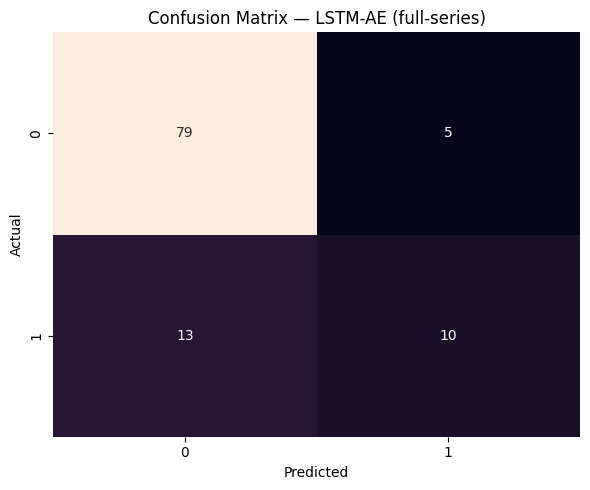

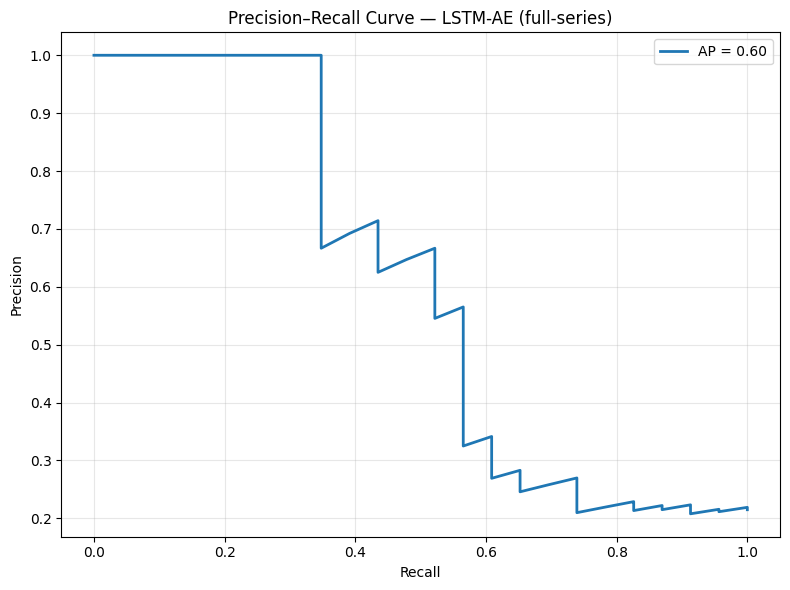

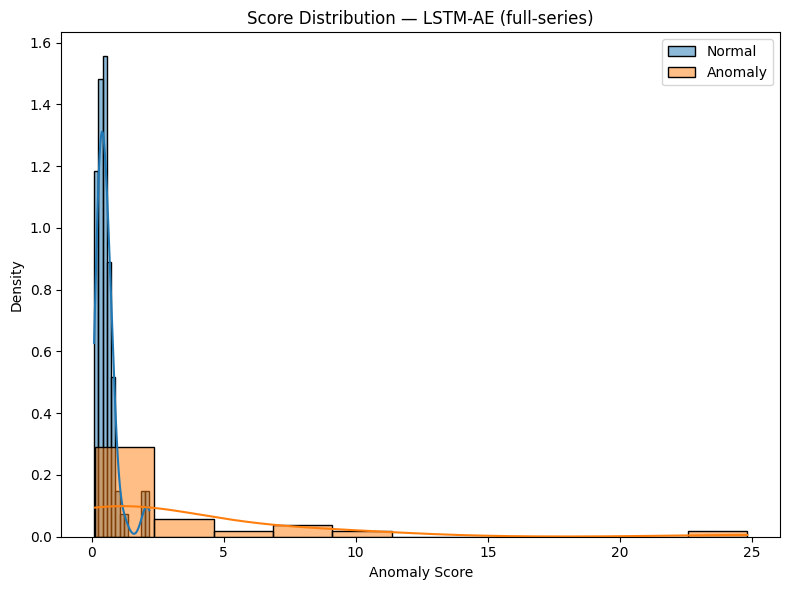

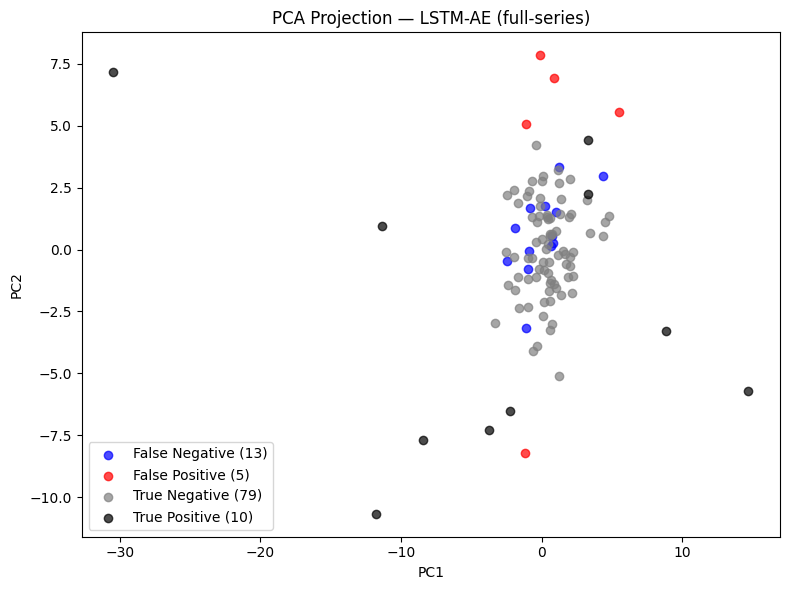

c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


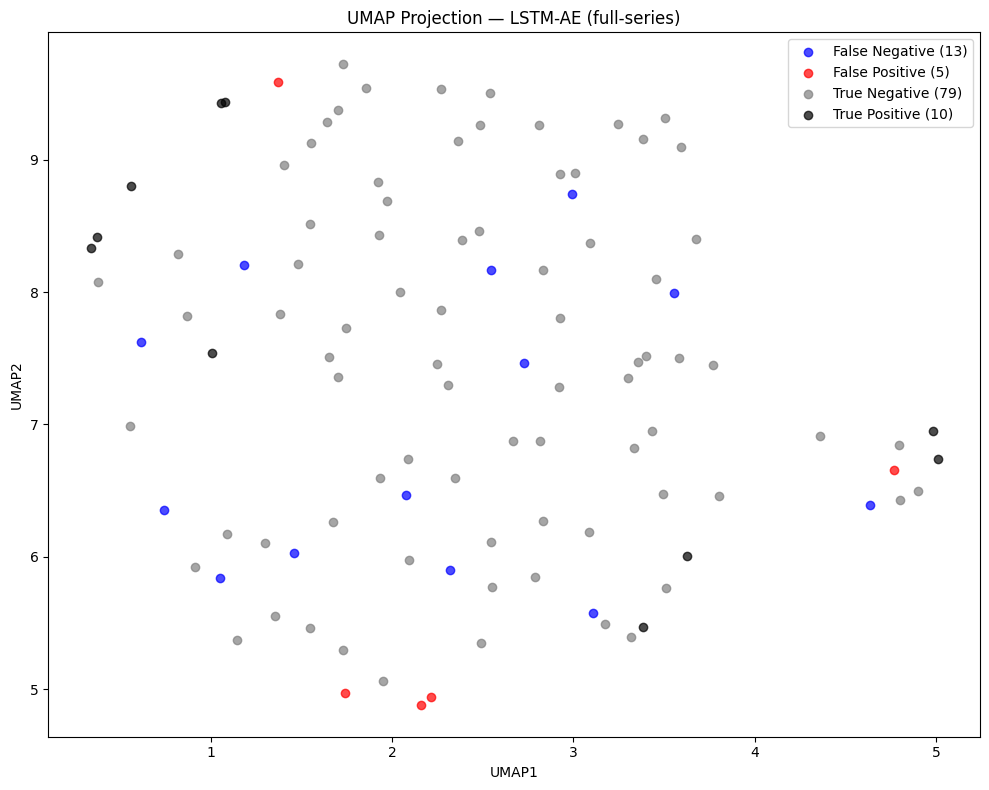

In [33]:
best = study.best_params
SEQ_LEN = best['seq_len']

# build windows & split
X_seq, y_seq = create_sequences(X_scaled, y, SEQ_LEN)
n = len(X_seq)
train_end = int(0.9 * n)

X_train_all = X_seq[:train_end][y_seq[:train_end] == 0]
X_test_seq  = X_seq[train_end:]            # still windows, but only used to compute start index
y_test_seq  = y_seq[train_end:]

train_loader = DataLoader(TensorDataset(torch.FloatTensor(X_train_all)), 
                          batch_size=best['batch_size'], shuffle=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTMAutoencoder(X_train_all.shape[2],
                        best['hidden_dim'], best['num_layers']).to(device)
optimizer = optim.Adam(model.parameters(), lr=best['lr'])
criterion = nn.MSELoss()

for epoch in range(1, 101):
    model.train()
    for seqs in train_loader:
        seqs = seqs[0].to(device)
        optimizer.zero_grad()
        out = model(seqs)
        loss = criterion(out, seqs)
        loss.backward()
        optimizer.step()

# --- 2) Translate window-based split into raw-series indices ---

# The first test window covers rows [train_end : train_end+SEQ_LEN]
# So the test‐period in X_scaled starts at:
test_start = train_end + (SEQ_LEN - 1)
X_test_series = X_scaled[test_start:]       # raw features for the 207 timestamps
y_test_series = y[test_start:]              # true labels for those same timestamps

# --- 3) Reconstruct & score every timestamp in the test‐slice ---

recon_test, err_test = model.reconstruct_full(X_test_series, seq_len=SEQ_LEN)

# threshold on normals only
thr = np.percentile(err_test[y_test_series == 0], 95)
pred_test = (err_test > thr).astype(int)

# --- 4) Final evaluation & plots ---

from sklearn.metrics import precision_score, recall_score, f1_score
print("Test Results:",
      "Precision:", precision_score(y_test_series, pred_test),
      "Recall:",    recall_score(y_test_series, pred_test),
      "F1:",        f1_score(y_test_series, pred_test))

model.plot_confusion_matrix(    y_test_series, pred_test, 'LSTM-AE (full-series)')
model.plot_precision_recall(   y_test_series, err_test,  'LSTM-AE (full-series)')
model.plot_score_histogram(    y_test_series, err_test,  'LSTM-AE (full-series)')
model.plot_pca(                X_test_series, y_test_series, pred_test, 'LSTM-AE (full-series)')
model.plot_umap(               X_test_series, y_test_series, pred_test, 'LSTM-AE (full-series)')
